In [4]:
%pylab inline
import gc
import galsim
import numpy as np
from fpfs import fpfsBase
import astropy.io.fits as pyfits

import numpy.lib.recfunctions as rfn

pltDir='plot/errors/'
vdir='outcome-var7em3'
def measure(galImgAll):
    imgList=[galImgAll[i//nx*ngrid+beg:i//nx*ngrid+end,i%nx*ngrid+beg:i%nx*ngrid+end] for i in range(ngal)]
    a=fpTask.measure(imgList)
    del imgList
    gc.collect()
    return a

Populating the interactive namespace from numpy and matplotlib


In [5]:
cd wrkDir/FPFS2/sim

/lustre/work/xiangchong.li/work/FPFS2/sim


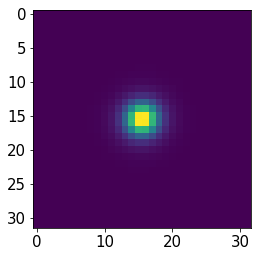

In [6]:
ngrid=64
nx=100;ny=100
ngal=nx*ny
scale=0.168
beta=0.75
psfFWHM=0.60
rcut=16
beg=ngrid//2-rcut
end=beg+2*rcut
# Initialize the fpfsTask
psfInt  =   galsim.Moffat(beta=3.5,fwhm=psfFWHM,trunc=psfFWHM*4.)
psfInt  =   psfInt.shear(e1=0.02,e2=-0.02)
psfImg  =   psfInt.drawImage(nx=64,ny=64,scale=scale)
psfData =   psfImg.array[beg:end,beg:end]
plt.imshow(psfData)
fpTask=fpfsBase.fpfsTask(psfData,beta=beta)

In [7]:
mms=[]
mms2=[]
mmsN=[]
mmsN2=[]
for igroup in range(8):
    # read galaxy image
    galImgAll=pyfits.getdata('galaxy_basic_psf%d/image-%d-g1-0000.fits' %(psfFWHM*100,igroup))
    #galImgAll=pyfits.getdata('galaxy_basic_psf%d/image-%d-g1-1111.fits' %(psfFWHM*100,igroup))
    mm=measure(galImgAll)
    mms.append(mm)
    del mm,galImgAll
    
    galImgAll=pyfits.getdata('galaxy_basic_psf%d/image-%d-g1-2222.fits' %(psfFWHM*100,igroup))
    #galImgAll=pyfits.getdata('galaxy_basic_psf%d/image-%d-g1-1111.fits' %(psfFWHM*100,igroup))
    mm=measure(galImgAll)
    mms2.append(mm)
    del mm,galImgAll
    
    ifield=igroup*250
    fname=os.path.join(vdir,'fpfs-rcut16-psf60-%d/src%04d-g1-0000.fits' %(igroup,ifield))
    mm=pyfits.getdata(fname)
    mmsN.append(mm)
    del mm,fname
    fname=os.path.join(vdir,'fpfs-rcut16-psf60-%d/src%04d-g1-2222.fits' %(igroup,ifield))
    mm=pyfits.getdata(fname)
    mmsN2.append(mm)
    del mm,fname
    gc.collect()
mms=rfn.stack_arrays(mms,usemask=False)
mms2=rfn.stack_arrays(mms2,usemask=False)
mmsN=rfn.stack_arrays(mmsN,usemask=False)
mmsN2=rfn.stack_arrays(mmsN2,usemask=False)

In [13]:
1./(2000/np.sqrt(np.average(mmsN2['fpfs_N00N00'])))**4.

0.028547240194583864

In [17]:
np.average(mmsN2['fpfs_N00N22c']/(mmsN2['fpfs_M00']+4000)**2.+mmsN['fpfs_N00N22c']/(mmsN['fpfs_M00']+4000)**2.)

6.40698857565487e-06

In [33]:
C=2000.
b=fpfsBase.fpfsM2E(mms,C)
b2=fpfsBase.fpfsM2E(mms2,C)
bN=fpfsBase.fpfsM2E(mmsN,C,rev=True)
bN2=fpfsBase.fpfsM2E(mmsN2,C,rev=True)

In [43]:
print(np.average((bN['fpfs_e1']-b['fpfs_e1'])*(bN['fpfs_s0']-b['fpfs_s0'])))
print(np.average((bN2['fpfs_e1']-b2['fpfs_e1'])*(bN2['fpfs_s0']-b2['fpfs_s0'])))


8.669346713338449e-06
4.9352862421027975e-06
0.027502405341859718
0.027494321658191125


In [46]:
mask=(b['fpfs_s0']<0.1)
print(np.std(bN[mask]['fpfs_e1']-b[mask]['fpfs_e1']))
print(np.std(bN2[mask]['fpfs_e1']-b2[mask]['fpfs_e1']))
print(np.std(bN2[mask]['fpfs_s0']-b2[mask]['fpfs_s0']))
print(np.average((bN2[mask]['fpfs_RS']-b2[mask]['fpfs_RS'])))
print(np.average((bN['fpfs_RS']-b['fpfs_RS'])))
print(np.average((bN2['fpfs_eSquare']-b2['fpfs_eSquare'])))
print(np.average((bN['fpfs_eSquare']-b['fpfs_eSquare'])))
print(np.average((b['fpfs_e1']**2.-b['fpfs_e2']**2.)))
print(np.average((bN['fpfs_RS'])))
print(np.average((bN['fpfs_RE'])))

0.02492098372380242
0.024916181373715523
0.019430345067564823
2.6900254271418086e-05
3.148411547179757e-05
5.378904911150133e-05
5.358928318664294e-05
6.759608094246548e-05
0.0011468195360870464
0.17529747421306435


In [47]:
def measE1Sq(moments,C):
    weight  =   1./(moments['fpfs_M00']+C) 
    ratio=  moments['fpfs_N00N00']*weight**2.
    weight= weight/(1+ratio)
    e1      =   moments['fpfs_M22c']*weight
    e1  =   (e1+moments['fpfs_N00N22c']\
            *weight**2.)/(1+ratio)
    
    e1sq    =   e1*e1
    e1sq=   (e1sq-moments['fpfs_N22cN22c']*weight**2.\
            +4.*e1*moments['fpfs_N00N22c']*weight**2.)\
            /(1.+3*ratio)
    return e1sq

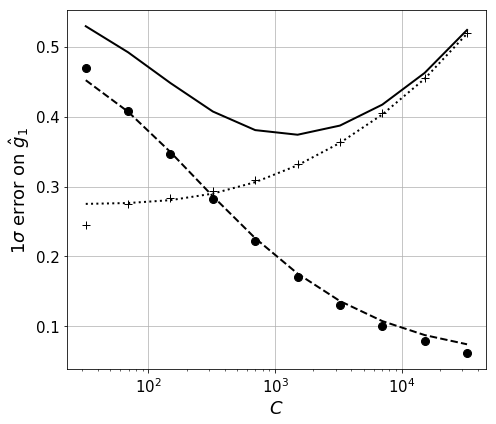

In [58]:
anaShapeNoise=[]
anaMeaNoise=[]
shapeNoise=[]
allNoise=[]
Clist=2**np.linspace(5,15,10)

for C in Clist:
    b=fpfsBase.fpfsM2E(mms,C)
    shapeNoise.append(np.std(b['fpfs_e1'])/np.average(b['fpfs_RE']))
    bN=fpfsBase.fpfsM2E(mmsN,C,rev=True)
    allNoise.append(np.std(bN['fpfs_e1'])/np.average(bN['fpfs_RE']))
    anaMeaNoise.append(np.sqrt(np.average(mmsN['fpfs_N22cN22c']/(mmsN['fpfs_M00']+C)**2.))/np.average(bN['fpfs_RE']))
    #e1sq=measE1Sq(mmsN,C)
    #anaShapeNoise.append(np.sqrt(np.average(e1sq))/np.average(bN['fpfs_RE']))
    del b,bN
    gc.collect
    
anaMeaNoise=np.array(anaMeaNoise)
anaShapeNoise=np.array(anaShapeNoise)
shapeNoise=np.array(shapeNoise)
allNoise=np.array(allNoise)
plt.close()
fig=plt.figure(figsize=(7,6))
ax=fig.add_subplot(1,1,1)
ax.plot(Clist,np.sqrt(allNoise**2-anaMeaNoise**2),c='black',ls='',marker='+',markersize=8)
#ax.plot(Clist,anaShapeNoise,c='black',ls='',marker='+',markersize=8)
ax.plot(Clist,anaMeaNoise,c='black',marker='o',ls='',markersize=8)
ax.plot(Clist,shapeNoise,c='black',ls=':')
ax.plot(Clist,np.sqrt(allNoise**2-shapeNoise**2),c='black',ls='--')
ax.plot(Clist,allNoise,c='black',ls='-')
ax.grid()

ax.set_xscale('log')
ax.set_xlabel(r'$C$')
ax.set_ylabel(r'$1\sigma$ error on $\hat{g}_1$')
plt.tight_layout()
fig.savefig(os.path.join(pltDir,'errors_252AllperGal.png'))
fig.savefig(os.path.join(pltDir,'errors_252AllperGal.pdf'))

In [6]:
e1I=[]
for igroup in range(8):
    # read galaxy image
    src=pyfits.getdata('galaxy_basic_psf60/hsm-%d-g1-0000.fits' %igroup)
    msk=((src['regauss_e1']**2.+src['regauss_e2']**2.)<=4.)
    src=src[msk]
    e1I.append(src['regauss_e1'])
    del src,msk
    gc.collect()
e1I=rfn.stack_arrays(e1I,usemask=False)

e1=[]
for igroup in range(8):
    # read galaxy image
    ifield=igroup*250
    src=pyfits.getdata('outcome-var7em3/src-psf60-%d/src%04d-g1-0000.fits' %(igroup,ifield))
    msk=(src['deblend_nChild']==0)&(~np.isnan(src['ext_shapeHSM_HsmShapeRegauss_e1']))&(~np.isnan(src['ext_shapeHSM_HsmShapeRegauss_e2']))
    msk&=((src['ext_shapeHSM_HsmShapeRegauss_e1']**2.+src['ext_shapeHSM_HsmShapeRegauss_e2']**2.)<=4.)
    src=src[msk]
    print(len(src))
    e1.append(src['ext_shapeHSM_HsmShapeRegauss_e1'])
    del src,msk
    gc.collect()
e1=rfn.stack_arrays(e1,usemask=False)

8622
8590
8587
8528
8551
8560
8612
8548


In [7]:
print(np.std(e1)/2./(1-np.average(e1I**2.))/np.sqrt(len(e1)))

0.0013870063363035391


In [8]:
C=2000.
bN=fpfsBase.fpfsM2E(mmsN,C)
print(np.std(bN['fpfs_e1'])/np.average(bN['fpfs_RE'])/np.sqrt(len(bN)))

0.0013265408839686643


In [9]:
C=1000.
bN=fpfsBase.fpfsM2E(mmsN,C)
print(np.std(bN['fpfs_e1'])/np.average(bN['fpfs_RE'])/np.sqrt(len(bN)))

0.0013141919490233446


In [10]:
0.0013141919490233446/0.0013870063363035391

0.9475024840374922